# Capstone Project - Car Accident Severity

In [23]:
# import relevant libraries
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# libraries for downloading csv file
import csv
import requests
import itertools

# libraries for visualisation
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter

# libraries from sklearn
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# libraries for data resampling
# conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


ModuleNotFoundError: No module named 'imblearn'

In [25]:
# load as pandas dataframe
df = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv")


C:\Users\atereo01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [22]:
df.head(3)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N


In [24]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [26]:
df.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

In [27]:
df.groupby('SEVERITYCODE')['SEVERITYDESC'].value_counts()

SEVERITYCODE  SEVERITYDESC                  
1             Property Damage Only Collision    136485
2             Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

In [13]:
df['SEVERITYDESC'].value_counts().to_frame() # choosing columns to use from the dataframe

,SEVERITYDESC
Property Damage Only Collision,136485
Injury Collision,58188


In [28]:
# exploring INTKEY unique values and counts
print(np.sort(df['INTKEY'].unique()))
print(len(df['INTKEY'].unique()))

[ 23807.  23808.  23811. ... 725404. 757580.     nan]
7615


In [29]:
# exploring junctiontype and addrtype relationship
df.groupby('ADDRTYPE')['JUNCTIONTYPE'].value_counts()

ADDRTYPE      JUNCTIONTYPE                                     
Alley         Mid-Block (not related to intersection)                176
              Driveway Junction                                       59
              At Intersection (but not related to intersection)        1
Block         Mid-Block (not related to intersection)              89330
              Mid-Block (but intersection related)                 22774
              Driveway Junction                                    10611
              Ramp Junction                                          133
              At Intersection (intersection related)                   4
              Unknown                                                  4
              At Intersection (but not related to intersection)        1
Intersection  At Intersection (intersection related)               62782
              At Intersection (but not related to intersection)     2094
              Ramp Junction                                 

In [30]:
# exploring crosswalkkey value counts
df['CROSSWALKKEY'].value_counts()

0         190862
523609        17
520838        15
525567        13
521707        10
           ...  
521019         1
630862         1
25545          1
523322         1
27186          1
Name: CROSSWALKKEY, Length: 2198, dtype: int64

               NON_ZERO_CROSSWALKKEY_COUNT  ZERO_CROSSWALKKEY_COUNT
COLLISIONTYPE                                                      
Angles                                   8                    34666
Cycles                                 627                     4788
Left Turn                                5                    13698
Other                                    4                    23699
Parked Car                               1                    47986
Pedestrian                            3104                     3504
Rear Ended                              10                    34080
Right Turn                               2                     2954
Sideswipe                                2                    18607


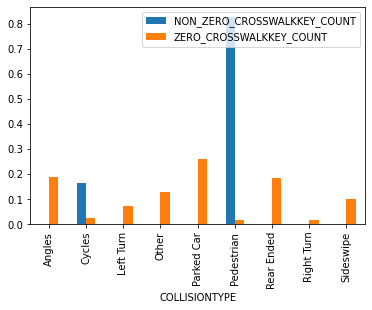

In [31]:
# filtering out CROSSWALKKEY according to non-zero and zero values, grouped by COLLISIONTYPE
del_df1 = df[df['CROSSWALKKEY'] !=0].groupby('COLLISIONTYPE').size().to_frame('NON_ZERO_CROSSWALKKEY_COUNT')
del_df2 = df[df['CROSSWALKKEY'] ==0].groupby('COLLISIONTYPE').size().to_frame('ZERO_CROSSWALKKEY_COUNT')

# merging 2 dfs and normalising along columns
del_df1 = pd.merge(del_df1, del_df2, on='COLLISIONTYPE')
print(del_df1)
del_df1 = (del_df1/del_df1.sum()).reset_index()

# plot 
del_df1.plot(x='COLLISIONTYPE', kind='bar')

plt.show()

In [32]:
# exploring SEGLANEKEY values
df['SEGLANEKEY'].value_counts()

0         191907
6532          19
6078          16
12162         15
10336         14
           ...  
35157          1
10817          1
15043          1
525169         1
16376          1
Name: SEGLANEKEY, Length: 1955, dtype: int64

               NON_ZERO_SEGLANEKEY_COUNT  ZERO_SEGLANEKEY_COUNT
COLLISIONTYPE                                                  
Angles                                 9                  34665
Cycles                              2668                   2747
Head On                                2                   2022
Left Turn                             14                  13689
Other                                 19                  23684
Parked Car                             2                  47985
Pedestrian                             4                   6604
Rear Ended                             4                  34086
Right Turn                             4                   2952
Sideswipe                              4                  18605


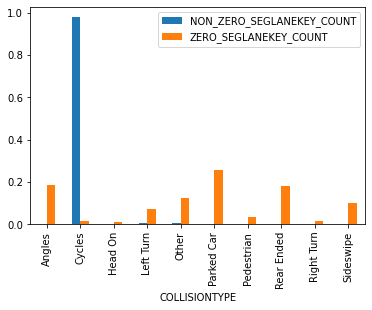

In [33]:

# filtering out SEGLANEKEY according to non-zero and zero values, grouped by COLLISIONTYPE
del_df1 = df[df['SEGLANEKEY'] !=0].groupby('COLLISIONTYPE').size().to_frame('NON_ZERO_SEGLANEKEY_COUNT')
del_df2 = df[df['SEGLANEKEY'] ==0].groupby('COLLISIONTYPE').size().to_frame('ZERO_SEGLANEKEY_COUNT')

# merging 2 dfs and normalising along columns
del_df1 = pd.merge(del_df1, del_df2, on='COLLISIONTYPE')
print(del_df1)
del_df1 = (del_df1/del_df1.sum()).reset_index()

# plot 
del_df1.plot(x='COLLISIONTYPE', kind='bar')
plt.show()

In [34]:
# list of features to keep

features = ['STATUS','ADDRTYPE', 'SEVERITYCODE','PERSONCOUNT', 'PEDCOUNT',
            'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE', 'INCDTTM','JUNCTIONTYPE',
            'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SEGLANEKEY','CROSSWALKKEY',
            'HITPARKEDCAR']

In [35]:
# create dataframe with features
df1 = df[features]

# lowercase all column header for easier manipulation
df1.columns = df1.columns.str.lower()

df1.head(3)

,status,addrtype,severitycode,personcount,pedcount,pedcylcount,vehcount,incdate,incdttm,junctiontype,weather,roadcond,lightcond,seglanekey,crosswalkkey,hitparkedcar
0,Matched,Intersection,2,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),Overcast,Wet,Daylight,0,0,N
1,Matched,Block,1,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,0,0,N
2,Matched,Block,1,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),Overcast,Dry,Daylight,0,0,N


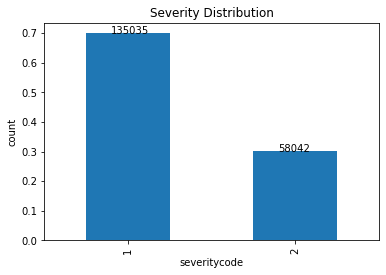

In [40]:
# plot the distribution of severitycode
data = df1['severitycode'].value_counts(normalize=True)
data.plot(kind='bar')

plt.xlabel('severitycode')
plt.ylabel('count')
plt.title('Severity Distribution')

# add data labels corresponding to the actual counts
for x, y in data.items():
    plt.text(x-1.1, y, str(df1['severitycode'].value_counts()[x]))
    
plt.show()

In [42]:
# create new dataframe copy consisting of severity and date columns
df_season = df1[['date', 'time','severitycode']]
df_season.head()

,date,time,severitycode
0,2013-03-27 00:00:00+00:00,2013-03-27 14:54:00,2
1,2006-12-20 00:00:00+00:00,2006-12-20 18:55:00,1
2,2004-11-18 00:00:00+00:00,2004-11-18 10:20:00,1
3,2013-03-29 00:00:00+00:00,2013-03-29 09:26:00,1
4,2004-01-28 00:00:00+00:00,2004-01-28 08:04:00,2


In [43]:
# find number of incidences per date entry
df_season_daily = df_season.groupby(['date'])['severitycode'].count()
df_season_daily

date
2004-01-01 00:00:00+00:00    25
2004-01-02 00:00:00+00:00    64
2004-01-03 00:00:00+00:00    20
2004-01-04 00:00:00+00:00    14
2004-01-05 00:00:00+00:00    18
                             ..
2020-05-16 00:00:00+00:00     5
2020-05-17 00:00:00+00:00     1
2020-05-18 00:00:00+00:00     2
2020-05-19 00:00:00+00:00     1
2020-05-20 00:00:00+00:00     1
Name: severitycode, Length: 5985, dtype: int64

<ipython-input-44-a73f19623cbd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['year'] = df_season['date'].dt.year


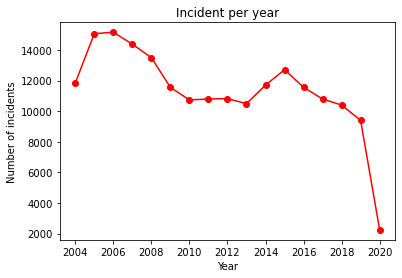

In [44]:
# By year

df_season['year'] = df_season['date'].dt.year
df_season.groupby(['year'])['severitycode'].count().plot(marker='o', color='r', label='Total')

plt.xlabel('Year')
plt.ylabel('Number of incidents')
plt.title('Incident per year')

plt.show()

<ipython-input-45-def110079982>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['day'] = df_season['date'].dt.dayofweek


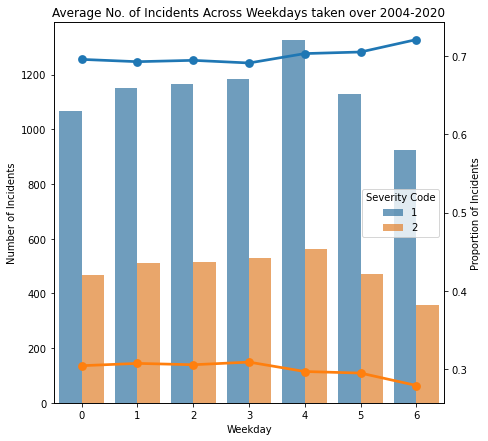

In [45]:
# By weekday

# create weekday values
df_season['day'] = df_season['date'].dt.dayofweek

# create df_season_weekday which shows the avg incident counts taken over 2004-2020 according to the weekdays, broken down into severitycode of 1 and 0
df_season_day = df_season.groupby(['day','severitycode'])['year'].value_counts().to_frame('counts').reset_index()
df_season_day  = df_season_day.groupby(['day', 'severitycode'])['counts'].mean().to_frame('counts').reset_index()

# create addition counts_proportion column that calculates the proportion of severity code 1 vs 0
counts_proportion = []
for day, total in (df_season_day.groupby(['day'])['counts'].sum()).items():
    counts_proportion.extend((df_season_day.loc[df_season_day['day'] == day, 'counts']/total).tolist())
df_season_day = df_season_day.assign(counts_proportion=counts_proportion)


fig, ax1 = plt.subplots(figsize=(7,7))
sns.barplot(data=df_season_day, x='day', y='counts', hue='severitycode', alpha=0.7, ax=ax1)

ax1.set_xlabel('Weekday')
ax1.set_ylabel('Number of Incidents')
ax1.set_title('Average No. of Incidents Across Weekdays taken over 2004-2020')
ax1.legend(loc='center right', title='Severity Code')


# create axes for 2ndplot, sharing same x-axis
ax2 = ax1.twinx()
# plot pointplot
sns.pointplot(data=df_season_day, x='day', y='counts_proportion', marker='o', hue='severitycode', ax=ax2)
# chart labels
ax2.set_ylabel('Proportion of Incidents')
ax2.legend_.remove()

plt.show()

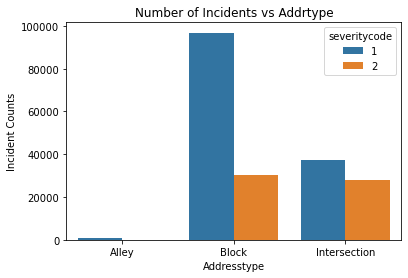

In [46]:
# lOCATION - by addrtype
data = df1.groupby(['addrtype'])['severitycode'].value_counts().to_frame('counts').reset_index()

sns.barplot(data=data, x='addrtype', y='counts', hue='severitycode')

plt.xlabel('Addresstype')
plt.ylabel('Incident Counts')
plt.title('Number of Incidents vs Addrtype')

plt.show()

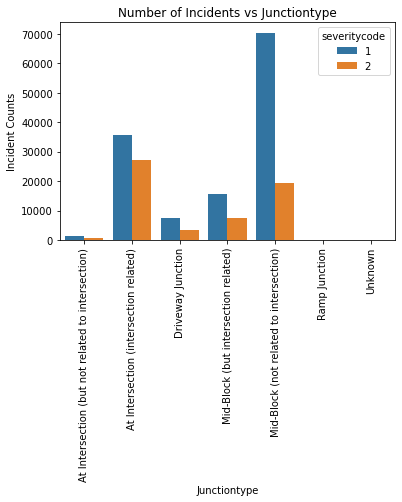

In [47]:
# by junctiontype
data = df1.groupby(['junctiontype'])['severitycode'].value_counts().to_frame('counts').reset_index()

sns.barplot(data=data, x='junctiontype', y='counts', hue='severitycode')

plt.xticks(rotation=90)
plt.xlabel('Junctiontype')
plt.ylabel('Incident Counts')
plt.title('Number of Incidents vs Junctiontype')

plt.show()